In [1]:
## --- Fast Import Snippet ---##
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os
import math, random
import copy
import pathlib
import time
import warnings
import itertools
import inspect
import numbers, string
import collections
from collections import namedtuple, OrderedDict
from pprint import pprint
from tqdm import tqdm

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
from PIL import Image

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader
import torchvision.transforms as T
import albumentations as A
from skimage.transform import resize as nd_resize
from scipy.ndimage import rotate as nd_rotate
from skimage import filters
from scipy import ndimage as ndi

np.set_printoptions(precision=3)
curr_path = pathlib.Path(os.getcwd()).parent.absolute()

cards = !echo $SGE_HGR_gpu_card
device = torch.device(f"cuda" if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Motivation Fig

In [2]:
checkpoint_file = '(0219_r2u101_pretr_mg)ep300_adamw,0002-wd0-cos_mse_r1'

### Get Model

from lib.nets.volumetric.res2unet3d import res2net101_v1b
model = res2net101_v1b(pretrained=False,  # no pretrained 3d net
                       base_width=26,
                       act='relu', norm='batchnorm',
                       in_channels=1, 
                       num_classes=1,
                       deep_sup=False)

curr_path = pathlib.Path(os.getcwd())
pre_artifact_path = curr_path / 'experiments' / 'prevec' / 'artifacts'
if not (pre_artifact_path / checkpoint_file).exists():
    pre_artifact_path = curr_path / 'experiments' / 'rubik' / 'artifacts'
assert (pre_artifact_path / checkpoint_file).exists()

checkpoint_path = None
for f in [pre_artifact_path / checkpoint_file / f for f in 
        os.listdir(pre_artifact_path / checkpoint_file)]:
    if str(f)[-3:] == 'pth':
        checkpoint_path = str(pre_artifact_path / f)
        print(f'\t Loaded Checkpoint: {checkpoint_path}')
assert checkpoint_path, f'No .pth files in {pre_artifact_path / checkpoint_file}'

checkpoint = torch.load(checkpoint_path, map_location='cpu')
cp_config = checkpoint['config']

print('⭐  Loading state dict for {cp_config.tasks.name}.')
print(model.load_state_dict(checkpoint['state_dict'], strict=False))

model = model.to(device)

💠 Res2UNet_3d model initiated with n_classes=1, 
   layers=[3, 4, 23, 3], base-width=26, scale=4, 
   in_chans=1, deep_sup=False, norm=batchnorm, act=relu, 
   params=67,777,025, trainable_params=67,777,025.
	 Loaded Checkpoint: /afs/crc.nd.edu/user/y/yzhang46/_3DPRE/src/experiments/prevec/artifacts/(0219_r2u101_pretr_mg)ep300_adamw,0002-wd0-cos_mse_r1/(0219_r2u101_pretr_mg)ep300_adamw,0002-wd0-cos_mse_r1_prevec_ep271_best-train-loss-0.005.pth
⭐  Loading state dict for {cp_config.tasks.name}.
<All keys matched successfully>


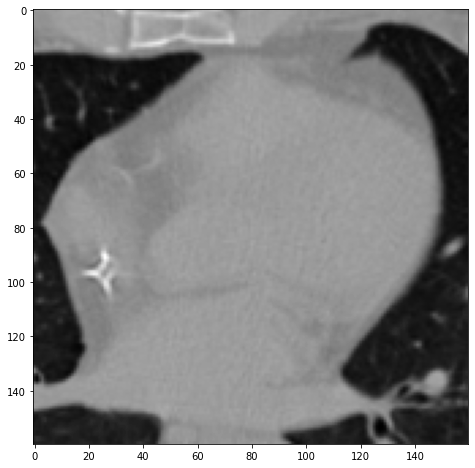

In [3]:
### Get Sample Data
datasets_dir = '/afs/crc.nd.edu/user/y/yzhang46/datasets/'
liver_dir = datasets_dir + 'MedicalSegmentationDecathlon/Task03_Liver/'
im_sitk = sitk.ReadImage(liver_dir + 'imagesTr/liver_8.nii.gz')

# Get array and preprocess
im_arr = sitk.GetArrayFromImage(im_sitk)
im_arr = np.flip(im_arr, axis=(1, 2))
mini, maxi = im_arr.min(), im_arr.max()
im_arr = (im_arr - mini) / (maxi - mini)

# Get Slice & Specific Crop
crop = im_arr[540 - 170:, 112:285, 192:358]    # 170, 173 x 166
fin_crop = nd_resize(crop, (160, 160, 160))

im_slice = nd_resize(im_arr[540], (512, 512))
crop = copy.copy(fin_crop)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(crop[-1], cmap='gray')
plt.show()

In [4]:
### Augmentations
from data.transforms.models_genesis import (
    local_pixel_shuffle, 
    nonlinear_intensity_map, 
    in_paint, 
    out_paint
)

shuffle = False
nonlin = False
inpaint = True
outpaint = False
visualize = False

batch = []
orig_slices = []
for b in range(10):
    
    # labels, boundaryies
    crop = copy.copy(fin_crop)
    y = copy.deepcopy(crop)
    filtered_crop = ndi.median_filter(y, size=5)
    schar_edges = filters.scharr(filtered_crop)
    boundary = np.clip((schar_edges - 0.01) * 30, 0, 1)
    
    if shuffle:
        crop = local_pixel_shuffle(
            crop, 
            p=1,
            n_shuffle_windows=15000,
            max_window_size_ratio=0.2
        )
    
    if nonlin:
        crop = nonlinear_intensity_map(
            crop, 
            p=1
        )
    
    if inpaint:
        crop, paint_mask = in_paint(crop, p=1.0,
            uniform_paint=True,
            n_paints=1000,
            get_paint_mask=True)
        
    if outpaint:
        crop, paint_mask = out_paint(crop, p=1.0,
            uniform_paint=True,
            n_paints=20,
            get_paint_mask=True)
    
    if visualize:
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(1, 1, 1)
        ax.imshow(crop[-1], cmap='gray')
        ax.set_title(f'Batch image {b+1}:')
        plt.show()
    
    batch.append(torch.tensor(crop))
    orig_slices.append(crop[-5])

batch = torch.stack(batch, 0).unsqueeze(1).to(device)
print(batch.shape)

print(f'⭐ Getting reconstructions!')

pred_slices = []
with torch.no_grad():
    recons = model(batch)['out'].sigmoid()
    
    for b in range(recons.shape[0]):
        pred_slice = recons[b,0][-5].cpu().numpy()
        pred_slices.append(pred_slice)
        if visualize:
            fig = plt.figure(figsize=(8,8))
            ax = fig.add_subplot(1, 1, 1)
            ax.imshow(pred_slice, cmap='gray')
            plt.show()

torch.Size([10, 1, 160, 160, 160])
⭐ Getting reconstructions!


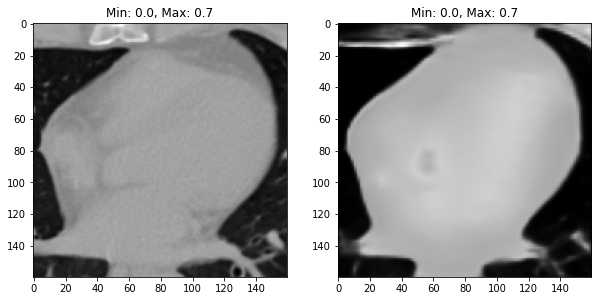

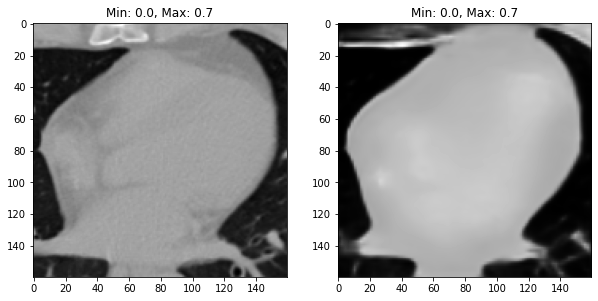

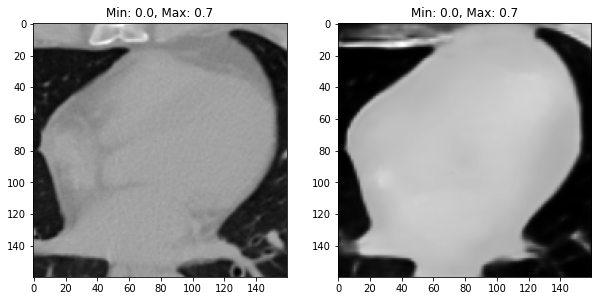

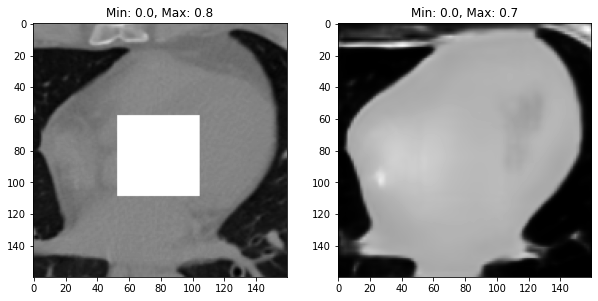

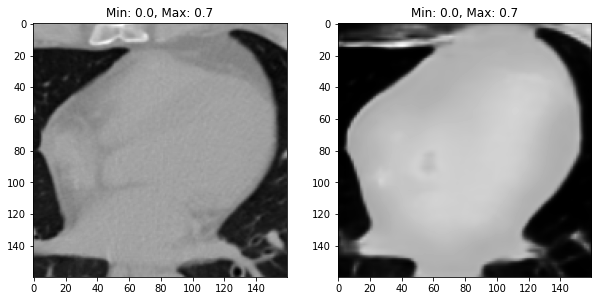

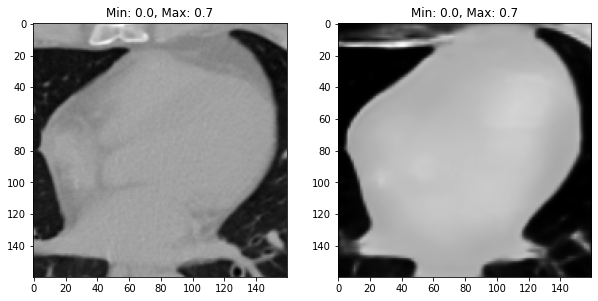

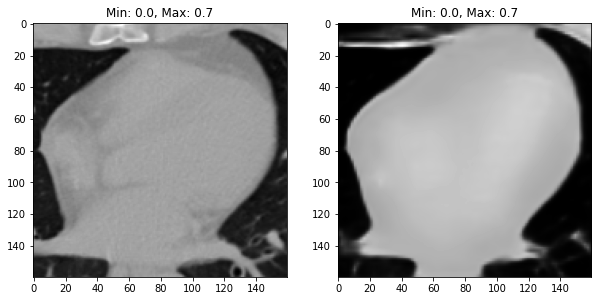

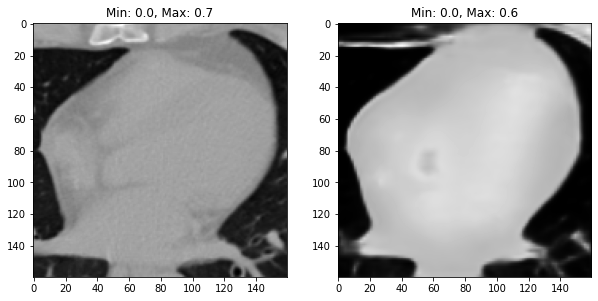

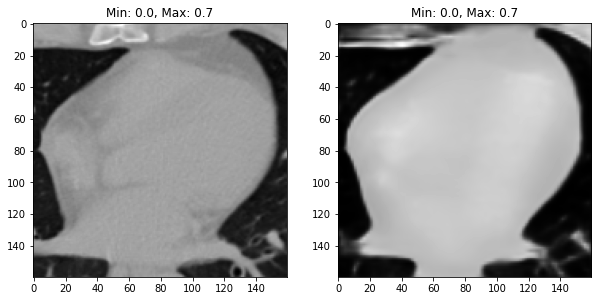

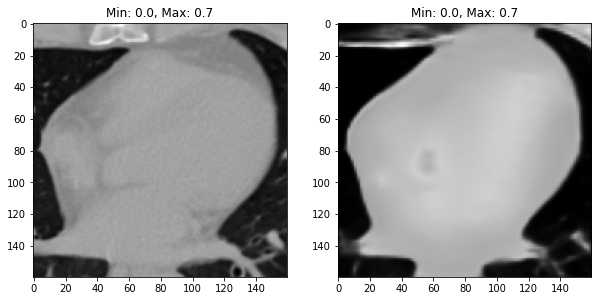

In [5]:
for b, (orig, pred) in enumerate(zip(orig_slices, pred_slices)):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(orig, cmap='gray')
    ax.set_title(f'Min: {orig.min():.1f}, Max: {orig.max():.1f}')
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(pred, cmap='gray')
    ax.set_title(f'Min: {pred.min():.1f}, Max: {pred.max():.1f}')
    plt.show()
